# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [185]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

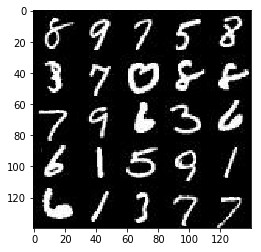

In [186]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

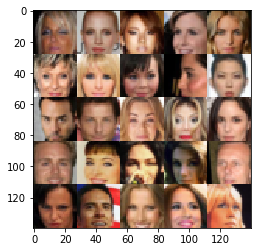

In [187]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [188]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/sunggeun/anaconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [189]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    return tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), name="real_input"),\
           tf.placeholder(tf.float32,(None, z_dim), name="z_input"),\
           tf.placeholder(tf.float32,(), name="learning_rate")


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [190]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        #first convolution layer
        l1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same', \
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(0.1 * l1, l1)
        
        #second convolution layer
        l2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same', \
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(l2, training=True)
        relu2 = tf.maximum(0.1 * bn2, bn2)
        
        #third convolution layer
        l3 = tf.layers.conv2d(bn2, 128, 5, strides=2, padding='same', \
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(l3, training=True)
        relu3 = tf.maximum(0.1 * bn3, bn3)
        
        #third convolution layer
        l4 = tf.layers.conv2d(bn3, 256, 5, strides=2, padding='same', \
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(l4, training=True)
        relu4 = tf.maximum(0.1 * bn4, bn4)
        
        #flatten
        flatten = tf.reshape(relu4, (-1, 2*2*256))
        
        #logit
        logit = tf.layers.dense(flatten, 1)
        
        #output
        output = tf.sigmoid(logit)
        
    return output, logit


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [191]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope("generator", reuse = not is_train):
        #fully connected layer
        f1 = tf.layers.dense(z, 4*4*512)

        r1 = tf.reshape(f1, (-1, 4, 4, 512))
        bn1 = tf.layers.batch_normalization(r1, training=is_train)
        relu1 = tf.maximum(0.1 * bn1, bn1)

        # deconvolution layer
        d2 = tf.layers.conv2d_transpose(relu1, 128, 4, strides=1, padding='valid', \
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(d2, training=is_train)
        relu2 = tf.maximum(0.1 * bn2, bn2)

        # deconvolution layer
        d3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, padding='same', \
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(d3, training=is_train)
        relu3 = tf.maximum(0.1 * bn3, bn3)

        # deconvolution layer
        d4 = tf.layers.conv2d_transpose(relu3, 32, 5, strides=2, padding='same', \
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(d4, training=is_train)
        relu4 = tf.maximum(0.1 * bn4, bn4)

        #logit
        logit = tf.layers.conv2d_transpose(relu4, out_channel_dim, 3, strides=1, padding='same',\
                                            kernel_initializer = tf.contrib.layers.xavier_initializer())

        #output
        output = tf.tanh(logit)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [192]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,\
                                                labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,\
                                                labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,\
                                                labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [193]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [194]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [195]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = 1 if data_image_mode == "L" else 3
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images * 2
                
                step += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, lr:learning_rate})
            
            
                if step % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))

                if step % 100 == 0:
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)           
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.6563... Generator Loss: 0.1379
Epoch 1/2... Discriminator Loss: 1.6134... Generator Loss: 0.3718
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 0.4576
Epoch 1/2... Discriminator Loss: 0.6466... Generator Loss: 4.4573
Epoch 1/2... Discriminator Loss: 1.4158... Generator Loss: 4.7752
Epoch 1/2... Discriminator Loss: 0.5530... Generator Loss: 2.0834
Epoch 1/2... Discriminator Loss: 0.5660... Generator Loss: 2.4708
Epoch 1/2... Discriminator Loss: 0.5119... Generator Loss: 4.0311
Epoch 1/2... Discriminator Loss: 0.7924... Generator Loss: 1.8414
Epoch 1/2... Discriminator Loss: 0.9953... Generator Loss: 2.1901


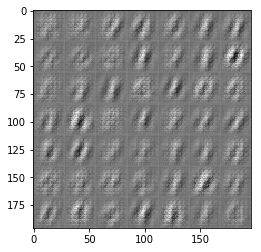

Epoch 1/2... Discriminator Loss: 0.6222... Generator Loss: 1.9971
Epoch 1/2... Discriminator Loss: 0.6700... Generator Loss: 2.5751
Epoch 1/2... Discriminator Loss: 0.9628... Generator Loss: 2.6998
Epoch 1/2... Discriminator Loss: 1.0279... Generator Loss: 2.6642
Epoch 1/2... Discriminator Loss: 0.9037... Generator Loss: 1.9566
Epoch 1/2... Discriminator Loss: 1.3145... Generator Loss: 0.8600
Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 1.2528
Epoch 1/2... Discriminator Loss: 0.9816... Generator Loss: 1.1477
Epoch 1/2... Discriminator Loss: 1.2141... Generator Loss: 0.8138
Epoch 1/2... Discriminator Loss: 1.2140... Generator Loss: 0.7632


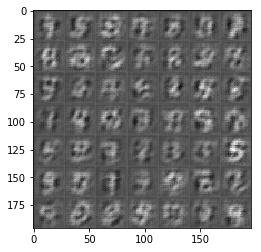

Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 1.2084
Epoch 1/2... Discriminator Loss: 1.1408... Generator Loss: 1.0110
Epoch 1/2... Discriminator Loss: 1.0370... Generator Loss: 0.8751
Epoch 1/2... Discriminator Loss: 1.0275... Generator Loss: 1.3012
Epoch 1/2... Discriminator Loss: 1.0256... Generator Loss: 1.0194
Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 1.9042
Epoch 1/2... Discriminator Loss: 0.9544... Generator Loss: 1.9730
Epoch 1/2... Discriminator Loss: 0.9314... Generator Loss: 2.3361
Epoch 1/2... Discriminator Loss: 0.9177... Generator Loss: 1.2613
Epoch 1/2... Discriminator Loss: 0.9863... Generator Loss: 1.0809


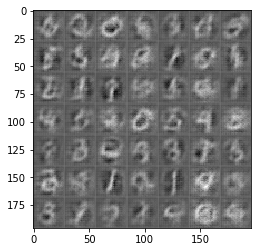

Epoch 1/2... Discriminator Loss: 0.8119... Generator Loss: 2.4300
Epoch 1/2... Discriminator Loss: 1.5049... Generator Loss: 0.5855
Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 0.7313
Epoch 1/2... Discriminator Loss: 1.2251... Generator Loss: 0.8118
Epoch 1/2... Discriminator Loss: 1.0322... Generator Loss: 0.9108
Epoch 1/2... Discriminator Loss: 1.0777... Generator Loss: 0.9190
Epoch 1/2... Discriminator Loss: 0.9513... Generator Loss: 1.0320
Epoch 1/2... Discriminator Loss: 0.8703... Generator Loss: 1.4379
Epoch 1/2... Discriminator Loss: 0.8243... Generator Loss: 1.4449
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.5597


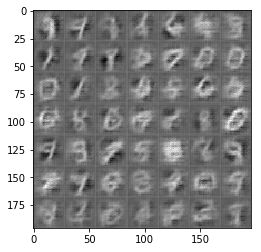

Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 0.9391
Epoch 1/2... Discriminator Loss: 1.1183... Generator Loss: 0.9031
Epoch 1/2... Discriminator Loss: 1.3223... Generator Loss: 0.7233
Epoch 1/2... Discriminator Loss: 0.9750... Generator Loss: 1.1180
Epoch 1/2... Discriminator Loss: 1.1863... Generator Loss: 1.2070
Epoch 1/2... Discriminator Loss: 1.1487... Generator Loss: 0.7898
Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 0.9556
Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 1.3700
Epoch 1/2... Discriminator Loss: 0.9243... Generator Loss: 1.1700
Epoch 1/2... Discriminator Loss: 0.8144... Generator Loss: 1.3291


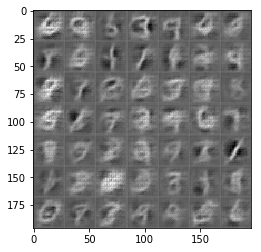

Epoch 1/2... Discriminator Loss: 1.0314... Generator Loss: 2.0088
Epoch 1/2... Discriminator Loss: 1.0649... Generator Loss: 1.1440
Epoch 1/2... Discriminator Loss: 1.1908... Generator Loss: 1.4986
Epoch 1/2... Discriminator Loss: 0.9958... Generator Loss: 1.0336
Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 1.3126
Epoch 1/2... Discriminator Loss: 1.2169... Generator Loss: 1.7477
Epoch 1/2... Discriminator Loss: 1.2522... Generator Loss: 0.6829
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 1.0847
Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 1.1588
Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 1.7216


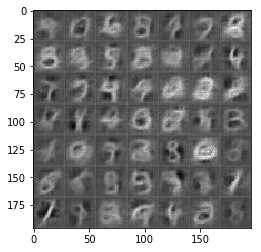

Epoch 1/2... Discriminator Loss: 0.9448... Generator Loss: 1.0227
Epoch 1/2... Discriminator Loss: 1.1349... Generator Loss: 1.0134
Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 1.0869
Epoch 1/2... Discriminator Loss: 1.1739... Generator Loss: 1.0738
Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 1.3823
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 1.0076
Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 0.5793
Epoch 1/2... Discriminator Loss: 1.1815... Generator Loss: 0.6778
Epoch 1/2... Discriminator Loss: 1.7251... Generator Loss: 0.3673
Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 0.6619


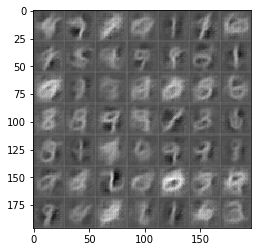

Epoch 1/2... Discriminator Loss: 1.0418... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 1.4851... Generator Loss: 0.4620
Epoch 1/2... Discriminator Loss: 0.9807... Generator Loss: 1.3741
Epoch 1/2... Discriminator Loss: 1.7346... Generator Loss: 1.8109
Epoch 1/2... Discriminator Loss: 1.1774... Generator Loss: 0.8025
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 0.7306
Epoch 1/2... Discriminator Loss: 1.0862... Generator Loss: 1.2126
Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 0.5757
Epoch 1/2... Discriminator Loss: 1.2770... Generator Loss: 0.6170
Epoch 1/2... Discriminator Loss: 1.4484... Generator Loss: 0.5601


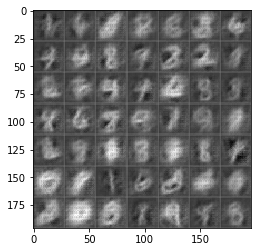

Epoch 1/2... Discriminator Loss: 1.3452... Generator Loss: 0.5180
Epoch 1/2... Discriminator Loss: 1.2743... Generator Loss: 0.7154
Epoch 1/2... Discriminator Loss: 2.7170... Generator Loss: 0.1415
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.5374
Epoch 1/2... Discriminator Loss: 1.2114... Generator Loss: 0.7166
Epoch 1/2... Discriminator Loss: 1.2059... Generator Loss: 1.2902
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 1.0872
Epoch 1/2... Discriminator Loss: 1.4133... Generator Loss: 0.5350
Epoch 1/2... Discriminator Loss: 1.2836... Generator Loss: 0.5620
Epoch 1/2... Discriminator Loss: 1.3782... Generator Loss: 0.5915


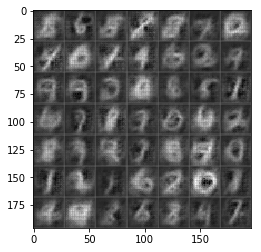

Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.4594
Epoch 1/2... Discriminator Loss: 1.4560... Generator Loss: 0.5169
Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 0.8853
Epoch 2/2... Discriminator Loss: 0.9406... Generator Loss: 1.1949
Epoch 2/2... Discriminator Loss: 1.0635... Generator Loss: 1.0230
Epoch 2/2... Discriminator Loss: 1.6083... Generator Loss: 0.3787
Epoch 2/2... Discriminator Loss: 1.1254... Generator Loss: 1.3648
Epoch 2/2... Discriminator Loss: 1.1056... Generator Loss: 1.1790
Epoch 2/2... Discriminator Loss: 1.1586... Generator Loss: 0.7340
Epoch 2/2... Discriminator Loss: 1.2276... Generator Loss: 0.7430


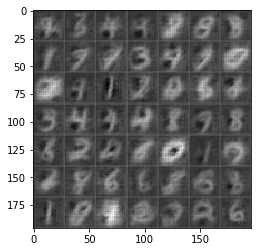

Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.5941
Epoch 2/2... Discriminator Loss: 1.0989... Generator Loss: 0.9070
Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 1.0125
Epoch 2/2... Discriminator Loss: 1.4065... Generator Loss: 0.5723
Epoch 2/2... Discriminator Loss: 1.0172... Generator Loss: 0.8803
Epoch 2/2... Discriminator Loss: 1.0472... Generator Loss: 0.9757
Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 0.5986
Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 0.9537
Epoch 2/2... Discriminator Loss: 1.0385... Generator Loss: 0.9035
Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 0.8165


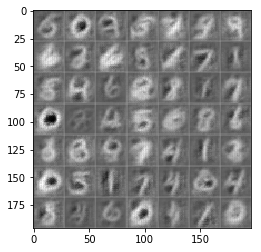

Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 0.8075
Epoch 2/2... Discriminator Loss: 1.2997... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 1.3450... Generator Loss: 0.5191
Epoch 2/2... Discriminator Loss: 1.5485... Generator Loss: 0.4330
Epoch 2/2... Discriminator Loss: 1.0339... Generator Loss: 1.0121
Epoch 2/2... Discriminator Loss: 1.0147... Generator Loss: 0.9426
Epoch 2/2... Discriminator Loss: 1.3325... Generator Loss: 0.5553
Epoch 2/2... Discriminator Loss: 0.8821... Generator Loss: 1.1063
Epoch 2/2... Discriminator Loss: 1.0837... Generator Loss: 1.6236
Epoch 2/2... Discriminator Loss: 2.5391... Generator Loss: 2.8425


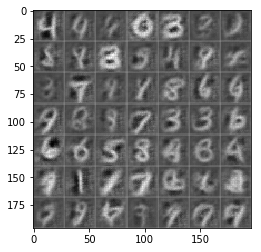

Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 1.4313
Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 1.1600
Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 1.4424
Epoch 2/2... Discriminator Loss: 1.0720... Generator Loss: 0.9559
Epoch 2/2... Discriminator Loss: 1.0458... Generator Loss: 1.1715
Epoch 2/2... Discriminator Loss: 1.0234... Generator Loss: 1.2103
Epoch 2/2... Discriminator Loss: 1.2279... Generator Loss: 0.6553
Epoch 2/2... Discriminator Loss: 1.2853... Generator Loss: 0.5923
Epoch 2/2... Discriminator Loss: 1.7166... Generator Loss: 0.3645
Epoch 2/2... Discriminator Loss: 1.2211... Generator Loss: 0.6223


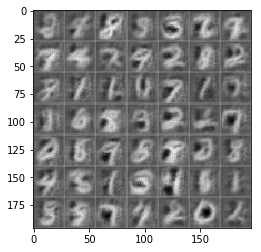

Epoch 2/2... Discriminator Loss: 1.1144... Generator Loss: 0.7744
Epoch 2/2... Discriminator Loss: 1.2286... Generator Loss: 1.3481
Epoch 2/2... Discriminator Loss: 1.0817... Generator Loss: 1.1963
Epoch 2/2... Discriminator Loss: 1.2774... Generator Loss: 0.6329
Epoch 2/2... Discriminator Loss: 1.1714... Generator Loss: 0.7978
Epoch 2/2... Discriminator Loss: 1.1974... Generator Loss: 0.6498
Epoch 2/2... Discriminator Loss: 1.3426... Generator Loss: 0.5463
Epoch 2/2... Discriminator Loss: 1.1047... Generator Loss: 0.7714
Epoch 2/2... Discriminator Loss: 1.2277... Generator Loss: 0.5877
Epoch 2/2... Discriminator Loss: 1.3080... Generator Loss: 0.5676


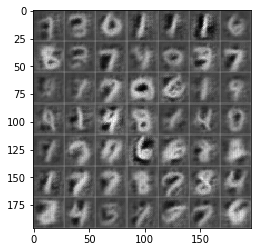

Epoch 2/2... Discriminator Loss: 1.5434... Generator Loss: 0.4278
Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 0.6008
Epoch 2/2... Discriminator Loss: 1.4692... Generator Loss: 0.4441
Epoch 2/2... Discriminator Loss: 1.1457... Generator Loss: 0.7899
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 0.5780
Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 1.3646
Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 1.4207
Epoch 2/2... Discriminator Loss: 1.6613... Generator Loss: 1.6189
Epoch 2/2... Discriminator Loss: 1.0170... Generator Loss: 0.9486
Epoch 2/2... Discriminator Loss: 1.0936... Generator Loss: 0.9325


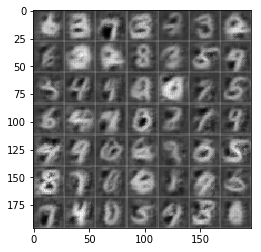

Epoch 2/2... Discriminator Loss: 1.5368... Generator Loss: 0.4446
Epoch 2/2... Discriminator Loss: 1.7938... Generator Loss: 0.3904
Epoch 2/2... Discriminator Loss: 1.0335... Generator Loss: 0.9168
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 0.8743
Epoch 2/2... Discriminator Loss: 0.9426... Generator Loss: 1.1930
Epoch 2/2... Discriminator Loss: 0.8944... Generator Loss: 1.3204
Epoch 2/2... Discriminator Loss: 1.1450... Generator Loss: 0.7121
Epoch 2/2... Discriminator Loss: 1.4669... Generator Loss: 1.7338
Epoch 2/2... Discriminator Loss: 1.1809... Generator Loss: 0.6437
Epoch 2/2... Discriminator Loss: 1.0269... Generator Loss: 1.3862


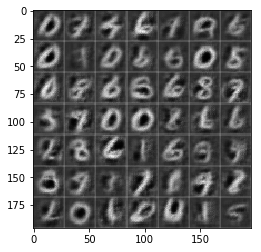

Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 1.6959
Epoch 2/2... Discriminator Loss: 1.0939... Generator Loss: 0.8105
Epoch 2/2... Discriminator Loss: 0.8981... Generator Loss: 1.1159
Epoch 2/2... Discriminator Loss: 1.5236... Generator Loss: 1.4497
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 0.9844
Epoch 2/2... Discriminator Loss: 1.1792... Generator Loss: 1.1252
Epoch 2/2... Discriminator Loss: 1.2084... Generator Loss: 0.6086
Epoch 2/2... Discriminator Loss: 1.3617... Generator Loss: 0.5062
Epoch 2/2... Discriminator Loss: 1.1563... Generator Loss: 0.6990
Epoch 2/2... Discriminator Loss: 1.4427... Generator Loss: 0.4800


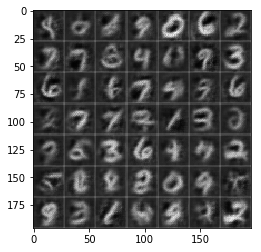

Epoch 2/2... Discriminator Loss: 1.5131... Generator Loss: 0.4510
Epoch 2/2... Discriminator Loss: 1.0931... Generator Loss: 0.7927
Epoch 2/2... Discriminator Loss: 1.2899... Generator Loss: 0.5682
Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 1.0772
Epoch 2/2... Discriminator Loss: 0.9808... Generator Loss: 0.9181
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 1.2050... Generator Loss: 0.6457
Epoch 2/2... Discriminator Loss: 1.1504... Generator Loss: 0.7213
Epoch 2/2... Discriminator Loss: 1.6280... Generator Loss: 0.4962
Epoch 2/2... Discriminator Loss: 0.9072... Generator Loss: 1.0739


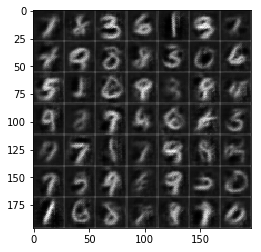

Epoch 2/2... Discriminator Loss: 0.8633... Generator Loss: 1.6223
Epoch 2/2... Discriminator Loss: 1.5113... Generator Loss: 1.4696
Epoch 2/2... Discriminator Loss: 1.0000... Generator Loss: 1.2898
Epoch 2/2... Discriminator Loss: 1.1476... Generator Loss: 1.0059
Epoch 2/2... Discriminator Loss: 0.9327... Generator Loss: 1.4254
Epoch 2/2... Discriminator Loss: 1.4950... Generator Loss: 0.4108
Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 0.6699


In [196]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 5.4002
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.2975
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 1.7181
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 2.6249
Epoch 1/1... Discriminator Loss: 2.0266... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 1.3559
Epoch 1/1... Discriminator Loss: 1.5838... Generator Loss: 0.4206
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.8512


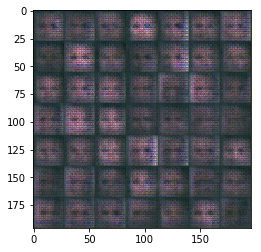

Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.7663... Generator Loss: 0.3803
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.5734
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.7264... Generator Loss: 0.3583
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.6427
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.1113
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 2.6617... Generator Loss: 2.9683


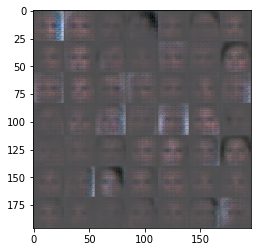

Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 1.5914
Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.4183
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 1.4182
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.5820


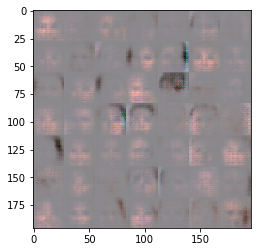

Epoch 1/1... Discriminator Loss: 1.7375... Generator Loss: 2.3292
Epoch 1/1... Discriminator Loss: 0.5796... Generator Loss: 1.8236
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.5293
Epoch 1/1... Discriminator Loss: 0.6789... Generator Loss: 1.7847
Epoch 1/1... Discriminator Loss: 2.0591... Generator Loss: 3.4381
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 1.4987
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.0855


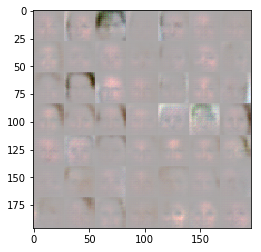

Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 2.2832
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 1.9286
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.9481
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 1.6122
Epoch 1/1... Discriminator Loss: 0.8832... Generator Loss: 1.5568
Epoch 1/1... Discriminator Loss: 0.6469... Generator Loss: 2.2932
Epoch 1/1... Discriminator Loss: 0.5025... Generator Loss: 2.8941
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 3.4273
Epoch 1/1... Discriminator Loss: 0.6960... Generator Loss: 2.2845


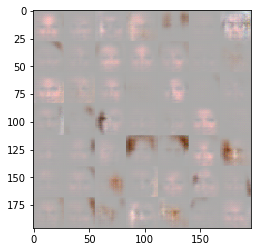

Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 2.1192
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.1947
Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 2.4000
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 2.0897
Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 1.2131
Epoch 1/1... Discriminator Loss: 0.5666... Generator Loss: 2.2450
Epoch 1/1... Discriminator Loss: 0.6374... Generator Loss: 1.6894
Epoch 1/1... Discriminator Loss: 0.7039... Generator Loss: 2.5294
Epoch 1/1... Discriminator Loss: 2.2830... Generator Loss: 2.5339
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.7734


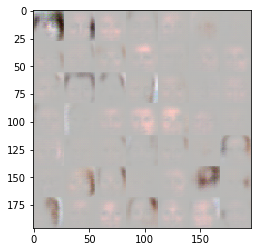

Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 1.7890
Epoch 1/1... Discriminator Loss: 0.4391... Generator Loss: 2.7795
Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 2.5032
Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 1.9150
Epoch 1/1... Discriminator Loss: 2.6871... Generator Loss: 3.5689
Epoch 1/1... Discriminator Loss: 0.6060... Generator Loss: 2.0354
Epoch 1/1... Discriminator Loss: 0.6843... Generator Loss: 1.3573
Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.2240
Epoch 1/1... Discriminator Loss: 0.6412... Generator Loss: 1.5196
Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 1.8741


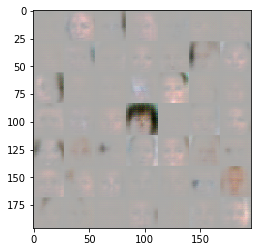

Epoch 1/1... Discriminator Loss: 0.5749... Generator Loss: 2.5129
Epoch 1/1... Discriminator Loss: 0.4851... Generator Loss: 2.7114
Epoch 1/1... Discriminator Loss: 0.7617... Generator Loss: 2.0962
Epoch 1/1... Discriminator Loss: 0.4619... Generator Loss: 2.4079
Epoch 1/1... Discriminator Loss: 0.6643... Generator Loss: 2.6783
Epoch 1/1... Discriminator Loss: 0.5044... Generator Loss: 2.5749
Epoch 1/1... Discriminator Loss: 0.6358... Generator Loss: 2.4182
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 0.5074... Generator Loss: 2.5189
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.5818


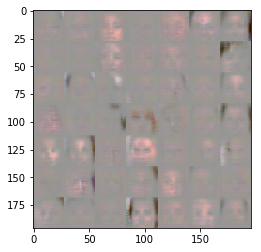

Epoch 1/1... Discriminator Loss: 2.0526... Generator Loss: 0.2350
Epoch 1/1... Discriminator Loss: 0.6737... Generator Loss: 3.1896
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 3.2797
Epoch 1/1... Discriminator Loss: 0.7361... Generator Loss: 2.8389
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 3.0284
Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 1.7719
Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 1.9100
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 1.3373
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 2.1035
Epoch 1/1... Discriminator Loss: 0.4331... Generator Loss: 2.8517


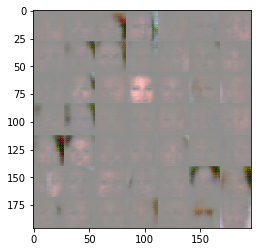

Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 2.7867
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 2.0561
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 3.6133
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 4.2466
Epoch 1/1... Discriminator Loss: 1.6779... Generator Loss: 3.9074
Epoch 1/1... Discriminator Loss: 0.7002... Generator Loss: 3.2330
Epoch 1/1... Discriminator Loss: 0.4823... Generator Loss: 2.3438
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.4499
Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 3.0692
Epoch 1/1... Discriminator Loss: 0.4716... Generator Loss: 2.9567


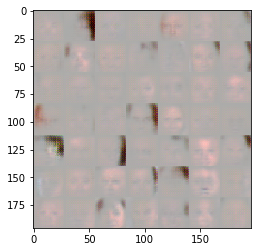

Epoch 1/1... Discriminator Loss: 0.5782... Generator Loss: 2.5450
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 3.0313
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 3.6844
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 3.1305
Epoch 1/1... Discriminator Loss: 0.5859... Generator Loss: 1.6418
Epoch 1/1... Discriminator Loss: 0.4503... Generator Loss: 3.6897
Epoch 1/1... Discriminator Loss: 0.4851... Generator Loss: 2.3371
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 3.1749
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 2.0869
Epoch 1/1... Discriminator Loss: 0.4464... Generator Loss: 2.7472


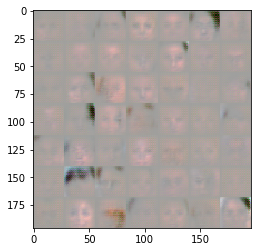

Epoch 1/1... Discriminator Loss: 0.5096... Generator Loss: 2.0933
Epoch 1/1... Discriminator Loss: 0.6074... Generator Loss: 1.7871
Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 2.6296
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 2.7187
Epoch 1/1... Discriminator Loss: 0.6129... Generator Loss: 1.6524
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.4759
Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 1.2054
Epoch 1/1... Discriminator Loss: 0.4037... Generator Loss: 3.0112
Epoch 1/1... Discriminator Loss: 0.4450... Generator Loss: 2.4305
Epoch 1/1... Discriminator Loss: 0.4181... Generator Loss: 2.8700


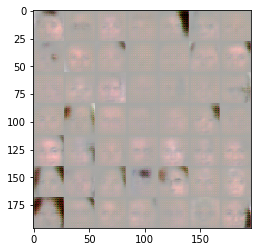

Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 2.7215
Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 2.4907
Epoch 1/1... Discriminator Loss: 1.5832... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 1.7827
Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 2.6785
Epoch 1/1... Discriminator Loss: 2.6620... Generator Loss: 2.8000
Epoch 1/1... Discriminator Loss: 0.6362... Generator Loss: 1.7049
Epoch 1/1... Discriminator Loss: 0.4779... Generator Loss: 2.9747
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 1.8008


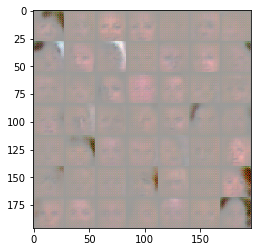

Epoch 1/1... Discriminator Loss: 0.6628... Generator Loss: 1.9618
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 0.6084... Generator Loss: 3.5624
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 2.8251
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 3.4375
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.1809
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 2.2372
Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 2.9091
Epoch 1/1... Discriminator Loss: 0.7040... Generator Loss: 2.7975


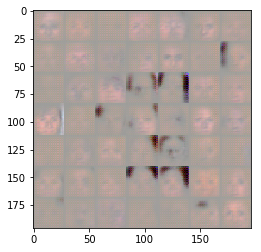

Epoch 1/1... Discriminator Loss: 0.4574... Generator Loss: 2.7736
Epoch 1/1... Discriminator Loss: 0.6023... Generator Loss: 3.5786
Epoch 1/1... Discriminator Loss: 0.5770... Generator Loss: 1.8022
Epoch 1/1... Discriminator Loss: 0.4213... Generator Loss: 2.9198
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 1.6671
Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 3.7706
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 2.8730
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 1.9028
Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 3.7236


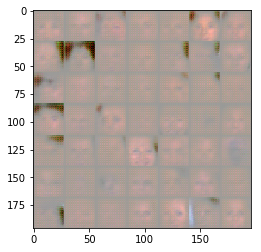

Epoch 1/1... Discriminator Loss: 0.5308... Generator Loss: 2.0516
Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 3.0997
Epoch 1/1... Discriminator Loss: 0.4783... Generator Loss: 2.3776
Epoch 1/1... Discriminator Loss: 0.4379... Generator Loss: 2.9030
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 4.6619
Epoch 1/1... Discriminator Loss: 0.7157... Generator Loss: 1.3665
Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 2.2902
Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 0.5689... Generator Loss: 3.4462
Epoch 1/1... Discriminator Loss: 2.4763... Generator Loss: 3.4173


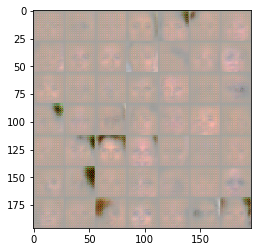

Epoch 1/1... Discriminator Loss: 0.6766... Generator Loss: 2.6832
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 3.7842
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 3.2218
Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 3.2497
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.2027
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 2.0841
Epoch 1/1... Discriminator Loss: 0.5105... Generator Loss: 3.3413
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 3.5735
Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 3.0831
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.6938


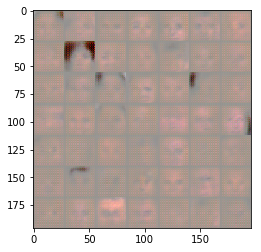

Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 2.8116
Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 3.0033
Epoch 1/1... Discriminator Loss: 0.4658... Generator Loss: 3.2784
Epoch 1/1... Discriminator Loss: 0.5139... Generator Loss: 2.1992
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 2.0622
Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 1.4191
Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 2.5277
Epoch 1/1... Discriminator Loss: 0.4414... Generator Loss: 3.1212
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.5797


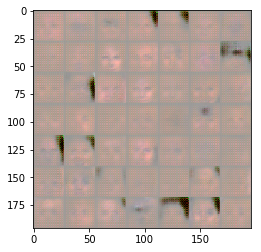

Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 1.9109
Epoch 1/1... Discriminator Loss: 0.4353... Generator Loss: 2.6849
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 3.5640
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 0.7054... Generator Loss: 1.6057
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 0.4653... Generator Loss: 2.7626
Epoch 1/1... Discriminator Loss: 0.4622... Generator Loss: 2.7573
Epoch 1/1... Discriminator Loss: 0.4895... Generator Loss: 2.4706


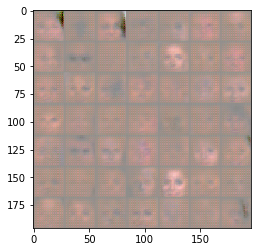

Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 1.8158
Epoch 1/1... Discriminator Loss: 0.5430... Generator Loss: 3.5495
Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 2.5711
Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 3.8699
Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 2.9592
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 1.9623
Epoch 1/1... Discriminator Loss: 0.4349... Generator Loss: 3.4756
Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 1.6694
Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 2.2056
Epoch 1/1... Discriminator Loss: 0.6384... Generator Loss: 3.4018


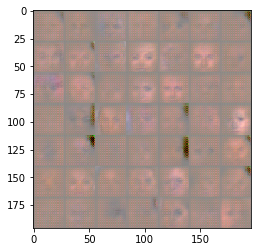

Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 1.8917
Epoch 1/1... Discriminator Loss: 0.4488... Generator Loss: 2.8424
Epoch 1/1... Discriminator Loss: 0.4306... Generator Loss: 3.5788
Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 2.2376
Epoch 1/1... Discriminator Loss: 0.5112... Generator Loss: 3.1209
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 2.2071
Epoch 1/1... Discriminator Loss: 0.6384... Generator Loss: 1.5470
Epoch 1/1... Discriminator Loss: 0.4711... Generator Loss: 3.3565
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 1.5955
Epoch 1/1... Discriminator Loss: 0.4634... Generator Loss: 2.6140


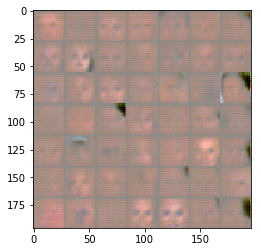

Epoch 1/1... Discriminator Loss: 0.5744... Generator Loss: 2.5848
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 4.4184
Epoch 1/1... Discriminator Loss: 0.4911... Generator Loss: 3.4532
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 1.4289
Epoch 1/1... Discriminator Loss: 0.4870... Generator Loss: 3.0133
Epoch 1/1... Discriminator Loss: 0.4409... Generator Loss: 3.8478
Epoch 1/1... Discriminator Loss: 0.4103... Generator Loss: 3.0996
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 4.1458
Epoch 1/1... Discriminator Loss: 0.4818... Generator Loss: 2.6462
Epoch 1/1... Discriminator Loss: 0.5052... Generator Loss: 3.8057


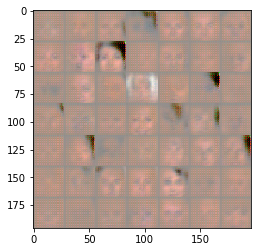

Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 3.5614
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.2517
Epoch 1/1... Discriminator Loss: 0.5805... Generator Loss: 1.8103
Epoch 1/1... Discriminator Loss: 0.6456... Generator Loss: 3.4571
Epoch 1/1... Discriminator Loss: 0.4910... Generator Loss: 2.4148
Epoch 1/1... Discriminator Loss: 0.4581... Generator Loss: 3.2772
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 2.3123
Epoch 1/1... Discriminator Loss: 0.7508... Generator Loss: 1.2733
Epoch 1/1... Discriminator Loss: 0.4320... Generator Loss: 3.2005


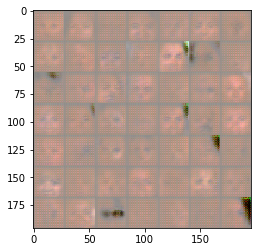

Epoch 1/1... Discriminator Loss: 0.9019... Generator Loss: 3.9254
Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 3.4094
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 2.0878
Epoch 1/1... Discriminator Loss: 0.7460... Generator Loss: 2.5594
Epoch 1/1... Discriminator Loss: 0.5297... Generator Loss: 2.0067
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 2.3517
Epoch 1/1... Discriminator Loss: 0.5218... Generator Loss: 2.6001
Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 3.5585
Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 2.6938


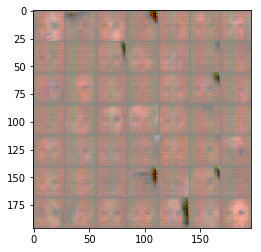

Epoch 1/1... Discriminator Loss: 0.5312... Generator Loss: 2.1849
Epoch 1/1... Discriminator Loss: 0.6207... Generator Loss: 2.9490
Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 1.7754
Epoch 1/1... Discriminator Loss: 0.4181... Generator Loss: 3.3146
Epoch 1/1... Discriminator Loss: 0.5391... Generator Loss: 1.9469
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.5128
Epoch 1/1... Discriminator Loss: 0.5776... Generator Loss: 2.7326
Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 2.4012
Epoch 1/1... Discriminator Loss: 0.6364... Generator Loss: 1.6690
Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 1.9003


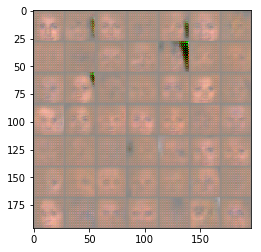

Epoch 1/1... Discriminator Loss: 0.6264... Generator Loss: 2.2247
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 1.8321
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 1.7773
Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 3.9775
Epoch 1/1... Discriminator Loss: 0.4450... Generator Loss: 2.9376
Epoch 1/1... Discriminator Loss: 0.4881... Generator Loss: 2.3067
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 3.2921
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 2.4067
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 0.5134... Generator Loss: 2.9554


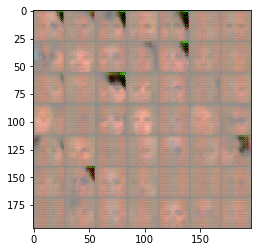

Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 2.2002
Epoch 1/1... Discriminator Loss: 0.4559... Generator Loss: 2.6181
Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 1.6780
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 2.0668
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 1.7410
Epoch 1/1... Discriminator Loss: 0.4567... Generator Loss: 2.9406
Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 2.5808
Epoch 1/1... Discriminator Loss: 0.4541... Generator Loss: 3.0577


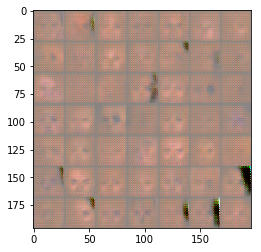

Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 2.8762
Epoch 1/1... Discriminator Loss: 2.7458... Generator Loss: 2.5528
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 1.5130
Epoch 1/1... Discriminator Loss: 0.5992... Generator Loss: 1.8098
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 3.7833
Epoch 1/1... Discriminator Loss: 0.5255... Generator Loss: 2.5752
Epoch 1/1... Discriminator Loss: 0.5898... Generator Loss: 2.4780
Epoch 1/1... Discriminator Loss: 0.4552... Generator Loss: 2.4997
Epoch 1/1... Discriminator Loss: 0.6335... Generator Loss: 1.5250
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.3399


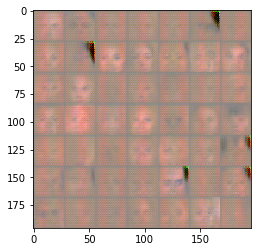

Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 3.4665
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 1.6751
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 3.1604
Epoch 1/1... Discriminator Loss: 0.4880... Generator Loss: 2.2835
Epoch 1/1... Discriminator Loss: 0.7179... Generator Loss: 2.5088
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 0.4585... Generator Loss: 2.6691
Epoch 1/1... Discriminator Loss: 0.4500... Generator Loss: 3.3185
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 2.3537
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 4.6450


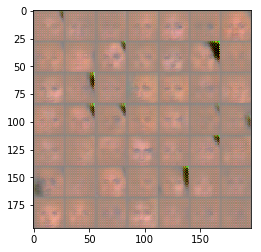

Epoch 1/1... Discriminator Loss: 0.7719... Generator Loss: 3.6912
Epoch 1/1... Discriminator Loss: 0.4468... Generator Loss: 2.7877
Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 2.6000
Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 2.9839
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 1.9077
Epoch 1/1... Discriminator Loss: 0.6711... Generator Loss: 2.8528
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 1.7590
Epoch 1/1... Discriminator Loss: 0.5409... Generator Loss: 1.9137
Epoch 1/1... Discriminator Loss: 1.7405... Generator Loss: 0.3733


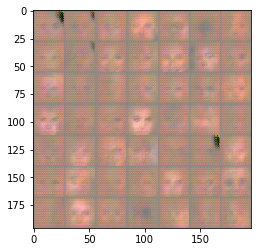

Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 2.8340
Epoch 1/1... Discriminator Loss: 0.6749... Generator Loss: 3.6974
Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 2.6312
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 3.5738
Epoch 1/1... Discriminator Loss: 0.4711... Generator Loss: 2.8888
Epoch 1/1... Discriminator Loss: 0.5276... Generator Loss: 2.1740
Epoch 1/1... Discriminator Loss: 0.5297... Generator Loss: 3.6616
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 3.2941
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 2.8098
Epoch 1/1... Discriminator Loss: 0.6036... Generator Loss: 1.8512


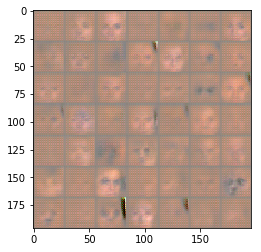

Epoch 1/1... Discriminator Loss: 0.5987... Generator Loss: 1.8629
Epoch 1/1... Discriminator Loss: 0.5787... Generator Loss: 3.7190
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 4.4309
Epoch 1/1... Discriminator Loss: 0.5564... Generator Loss: 3.6233
Epoch 1/1... Discriminator Loss: 0.7792... Generator Loss: 1.5499
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.0019


In [197]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.